In [1]:
%load_ext autoreload
%autoreload 2

import os
import keras
#import umap
#import altair as alt
import json
import pickle as pk
#from weblogo import *
#from tqdm import tqdm
import matplotlib

import pandas as pd
import seaborn as sns
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import utils.metrics as utils_metrics
from sklearn.metrics import confusion_matrix

from keras import backend as K
from keras import metrics
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, Lambda
from keras.optimizers import Adam
from keras.layers import Input, MaxPool1D, Dropout, LSTM, Bidirectional
from keras.models import Model
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import UpSampling1D
from keras.layers import BatchNormalization
from keras.layers import Layer

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from keras.utils import to_categorical

import utils.data_processing as dp
import utils.visualization as viz
import utils.models as models
import utils.set_env as se
import utils.metrics as um

Using TensorFlow backend.
/home/apps/software/Tensorflow-GPU/1.2.1-IGB-gcc-4.9.4-Python-3.6.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/apps/software/Tensorflow-GPU/1.2.1-IGB-gcc-4.9.4-Python-3.6.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/apps/software/Tensorflow-GPU/1.2.1-IGB-gcc-4.9.4-Python-3.6.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as

In [2]:
def vis_res(data_dict, network_dict, w, n_class, iteration, viz, acc_only=False):
    ep_dict = {}
    df_tmp = data_dict['df_train'].copy().reset_index(drop=True)
    for i, k in enumerate(data_dict['vc_train'].index):
        idx = df_tmp[df_tmp['antigen.epitope'] == k].index[0]
        tmp = data_dict['y_enc_train'][idx:idx+1]
        ep_dict[i] = tmp

    res_tmp = {}
    for k, v in ep_dict.items():
        ep_tmp = np.tile(v, (data_dict['X_test'].shape[0],1,1))
        nll_out = network_dict['NLL'].predict([data_dict['X_test'], ep_tmp])
        res_tmp[k] = nll_out

    res_tmp_train = {}
    for k, v in ep_dict.items():
        ep_tmp = np.tile(v, (data_dict['X_train'].shape[0],1,1))
        nll_out = network_dict['NLL'].predict([data_dict['X_train'], ep_tmp])
        res_tmp_train[k] = nll_out

    to_stack = []
    to_stack_train = []
    for v in res_tmp.values():
        to_stack.append(v)
    for v in res_tmp_train.values():
        to_stack_train.append(v)
    
    stack = np.vstack(to_stack)
    max_likelihood_out = np.argmin(stack, axis=0)
    
    test_cat = to_categorical(max_likelihood_out)

    stack_train = np.vstack(to_stack_train)
    max_likelihood_out_train = np.argmin(stack_train, axis=0)
    train_cat = to_categorical(max_likelihood_out_train)

    max_out = confusion_matrix(max_likelihood_out, data_dict['y_cls_test']).transpose()

    max_out_train = confusion_matrix(max_likelihood_out_train, data_dict['y_cls_train']).transpose()

    #alpha = get_alpha(data_dict['y_cls_train'], max_likelihood_out_train, w, n_class)
    
    if viz:
        um.viz_conf_mat(max_out_train, data_dict['vc_train'], 'Confusion Matrix Train {}'.format(iteration), acc_only)
        acc = um.viz_conf_mat(max_out, data_dict['vc_train'], 'Confusion Matrix Test {}'.format(iteration), acc_only)
    else:
        acc = um.viz_conf_mat(max_out, data_dict['vc_train'], 'Confusion Matrix Test {}'.format(iteration), acc_only)
    return max_likelihood_out_train, max_likelihood_out, train_cat, test_cat, res_tmp, stack, acc, to_stack, to_stack_train, stack_train

In [20]:
#alt.data_transformers.enable('default', max_rows=None)
#reducer = umap.UMAP(n_neighbors=15)

TCR_PAD_LEN = 20
EP_PAD_LEN = 10
NCH = 6
TCR_SHAPE= (TCR_PAD_LEN, NCH)
EP_SHAPE = (EP_PAD_LEN, NCH)
#paths = se.make_paths()

#aa_vec = se.get_aa_vec()

In [33]:
aa_vec = pk.load(open('atchley.pk', 'rb'))

In [34]:
df_dedup = pk.load(open('df_dedup.pk', 'rb'))

In [35]:
df_bg_groom = pk.load(open('df_dryad.pk', 'rb'))

In [50]:
#n_classes_list = [2, 3, 4, 5]
n_classes_list = [2]
neg_list = [0.5]
n_runs = 5
class_epoch_dict = {
    2: 250, #250
    3: 180,
    4: 140,
    5: 120
}


neg = 0.5
groom = True
total_dict_groom = {}
for n_classes in n_classes_list:
    for neg in neg_list:
        for sample in ['over']:
            total_dict_groom[(n_classes, neg, sample)] = {'acc': [],
                                                          'auc_dicts': []}

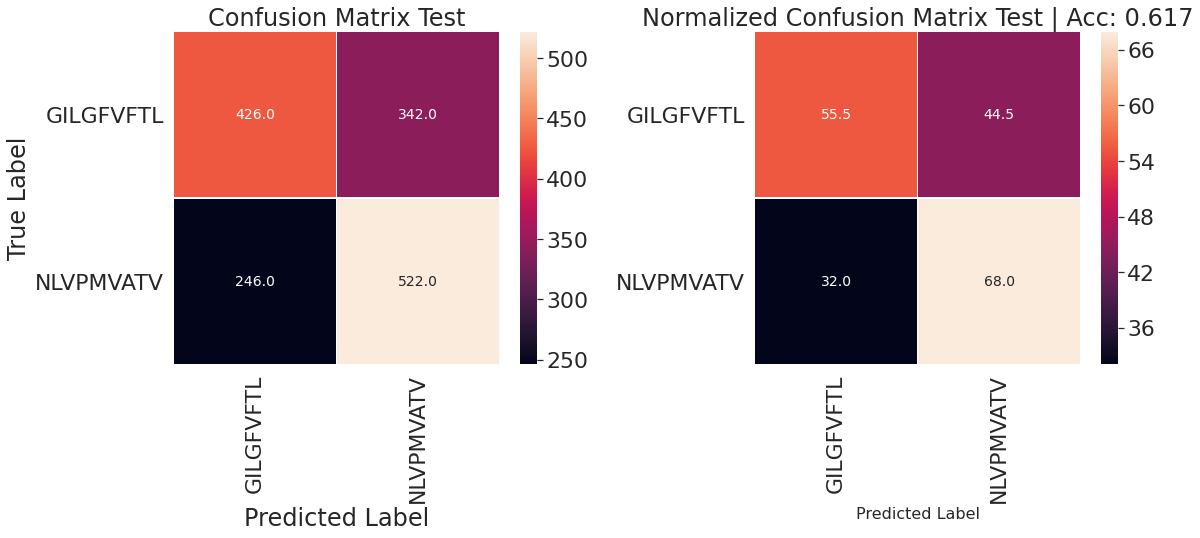

(2, 0.5, 'over') {'acc': [0.6171875], 'auc_dicts': [{'GILGFVFTL': 0.7532275390625001, 'NLVPMVATV': 0.7280658203125}]}


KeyboardInterrupt: 

In [51]:
for r in range(1):
    for j in range(n_runs):
        for n_classes in n_classes_list:
            for neg in neg_list:
                for sample in ['over']:
                    if groom:
                        df_filt_dedup10 = df_dedup
                    else:
                        df_filt_dedup10 = df_filt_dedup[df_filt_dedup['antigen.epitope'].apply(len) <= 10]

                    vc10 = df_filt_dedup10['antigen.epitope'].value_counts()

                    df_top = df_filt_dedup10[df_filt_dedup10['antigen.epitope'].isin(vc10.index[:n_classes])]

                    df_bg_groom = df_bg_groom.sample(frac=1, replace=False)
                    df2_first = df_bg_groom[:70000]

                    df2_second = df_bg_groom[70000:80000]
                    split_dict = dp.split_train_neg(df_top, 0.8, 0, df2_first, neg, True, True, sample)
                    data_dict = dp.make_data_dict_neg(split_dict, aa_vec=aa_vec, tcr_pad_len=20, ep_pad_len=10)
                    network_dict_neg = models.make_full_network_neg(None)
                    n_epoch = class_epoch_dict[n_classes]
                    #if sample == 'over':
                    #    n_epoch = 175
                    #elif sample == 'geo':
                    #    n_epoch = 700
                    test_tmp = models.train(network_dict_neg, data_dict, 128, n_epoch, 10, choice_idx=None, auto_stop_n=100)
                    ep_dict = {}
                    df_tmp = data_dict['df_train'].copy().reset_index(drop=True)
                    for i, k in enumerate(data_dict['vc_train'].index):
                        idx = df_tmp[df_tmp['antigen.epitope'] == k].index[0]
                        tmp = data_dict['y_enc_train'][idx:idx+1]
                        ep_dict[i] = tmp

                    res_tmp = {}
                    for k, v in ep_dict.items():
                        ep_tmp = np.tile(v, (data_dict['X_test'].shape[0],1,1))
                        nll_out = network_dict_neg['NLL'].predict([data_dict['X_test'], ep_tmp])
                        res_tmp[k] = nll_out

                    to_stack = []
                    for v in res_tmp.values():
                        to_stack.append(v)

                    stack = np.vstack(to_stack)
                    max_likelihood_out = np.argmin(stack, axis=0)

                    valid_idx = np.where(data_dict['y_cls_test'] != -1)[0]

                    max_l_out_3 = max_likelihood_out[valid_idx]
                    cls_test_3 = data_dict['y_cls_test'][valid_idx]

                    max_out = confusion_matrix(max_l_out_3, cls_test_3).transpose()

                    acc = um.viz_conf_mat(max_out, data_dict['vc_train'], 'Confusion Matrix Test', False, (17,8))
                    total_dict_groom[(n_classes, neg, sample)]['acc'].append(acc)

                    new_dict = {}
                    n_classes = df_top['antigen.epitope'].value_counts().shape[0]
                    roc_dict = {}
                    for k in range(n_classes):
                        ep_tmp = np.tile(ep_dict[k], (df2_second['cdr3'].shape[0],1,1))
                        X_neg = dp.encode_seq_array(df2_second['cdr3'], aa_vec, True, TCR_PAD_LEN)
                        nll_out = -1*network_dict_neg['NLL'].predict([X_neg, ep_tmp])
                        neg_score = list(nll_out)
                        #viz_status = True
                        #acc_onlay = False
                        #out = vis_res(data_dict, network_dict, None, 10, 1, viz_status, acc_only)
                        pos_score = []
                        #neg_score = []
                        for i, elem in enumerate(data_dict['y_cls_test']):
                            if elem == k:
                                pos_score.append(-1*stack[elem,i])
                        score = np.array(pos_score + neg_score)
                        y = [1]*len(pos_score) + [0]*len(neg_score)
                        roc_data = roc_curve(y, score, pos_label=1)
                        roc_dict[k] = roc_data
                        auc_score = auc(roc_data[0], roc_data[1])
                        new_dict[data_dict['vc_train'].index[k]] = auc_score
                    #pk.dump(roc_dict, open('n{}_roc_{}.pk'.format(n_classes, j), 'wb'))

                    total_dict_groom[(n_classes, neg, sample)]['auc_dicts'].append(new_dict)
                    print((n_classes, neg, sample), total_dict_groom[(n_classes, neg, sample)])